# Vorgeplänkel zur Belegarbeit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from metpy.plots import Hodograph

# figure beautification
%config InlineBackend.figure_format = 'retina'

### ToDo
- Wie sieht sounding zu Beginn aus?
- Reflectivity darstellen
- Auf curta rechnen ✔️

### Notes
- **tasks** = CPUs = Kerne & **nodes** = Knoten = PCs
- If `imove` = 1, two output fields are generated.  The first (rn) is the accumulated rainfall at model grid points.  The second (rn2) is the translated rainfall pattern, assuming a lower surface is moving at `umove` and `vmove`.
- (synchronisierter) pfad auf curta: `/remote/trove/geo/ifm/model/work/WS2023/rw0064fu/cm1/`

### CM1-Simulationen

#### `proj-windmax-10`:
- stationary domain, `imove` = 0
- `dx`, `dy` = 500m, `dz` = 250m, 240x240x80 grid
- simulation duration `timmax` = 2h, time step `dtl` = 1.5s, output frequency `tapfrq` = 5min
- base-state sounding `isnd` = 5 (Weisman-Klemp supercell)
- `iinit` = 1 (warm bubble)
- microphysics `ptype` = 5 (two-moment Morrison scheme, necessary for reflectivity output)
- large ice category `ihail` = 1 (hail)
- wind profile `iwnd` = 1 (RKW-type, see below)
  - `udep1` = 0, `udep2` = 2500m, `uconst1` = 0, `uconst2` = 10m/s

#### `proj-windmax-10-vconst`:
- add constant wind in v-direction (`var5` = 5m/s)
- new namelist parameters are initialised in `input.F` _twice_
- change location of warm bubble via extra namelist #20:
```
! initialisierung der bubble werte
        bubble_zc      =  1400.0
        bubble_bhrad   = 10000.0
        bubble_bvrad   =  1400.0
        bubble_bptpert =     1.0
        bubble_x = centerx
        bubble_y = centery

! namelist wird hier eingelesen

        ric = bubble_x
        rjc = bubble_y
        !ric     =  centerx  ! center of bubble in x-direction (m)
        !rjc     =  centery  ! center of bubble in y-direction (m)
        !zc      =   1400.0  ! height of center of bubble above ground (m)
        !bhrad   =  10000.0  ! horizontal radius of bubble (m)
        !bvrad   =   1400.0  ! vertical radius of bubble (m)
        !bptpert =      1.0  ! max potential temp perturbation (K)
        zc      =   bubble_zc
        bhrad   =   bubble_bhrad
        bvrad   =   bubble_bvrad
        bptpert =   bubble_bptpert
```

#### `curta:pro-windmax-20`

- `dx`, `dy` = 500m, `dz` = 250m, 400x200x80 grid
- `ppnode` = 16
- wind profile: `uconst2` = 20m/s
- bubble center: `bubble_x` = -80km, `bubble_y` = -30km

In [2]:
# plot hodograph for selected wind profile
# iwnd = 1; RKW-type wind profile
# defaults:
# udep1   =     0.0    ! height of bottom of shear layer (m)
# udep2   =  2500.0    ! height of top of shear layer (m)
# uconst1 =     0.0    ! u at bottom of shear layer
# uconst2 =    10.0    ! u at top of shear layer

def wndprofile(z, udep1, udep2, uconst1, uconst2):
    # initialise wind vectors
    u = np.zeros(len(z))
    v = np.zeros(len(z))
    
    # u-direction
    for i in range(len(u)):
        if z[i] < udep1:
            u[i] = uconst1
        elif z[i] >= udep1 and z[i] <= udep2:
            u[i] = (uconst2-uconst1) * (z[i]-udep1)/(udep2-udep1) + uconst1
        else:
            u[i] = uconst2

    return u, v

[   0.          357.14285714  714.28571429 1071.42857143 1428.57142857
 1785.71428571 2142.85714286 2500.         2857.14285714 3214.28571429
 3571.42857143 3928.57142857 4285.71428571 4642.85714286 5000.        ]


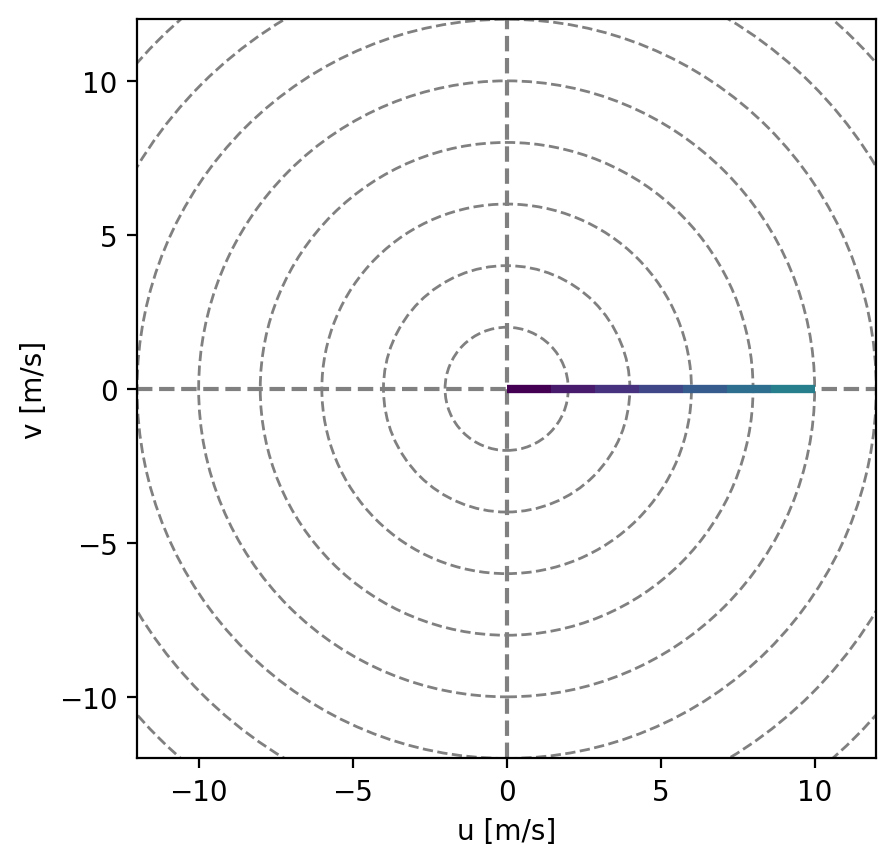

In [3]:
zh = np.linspace(0, 5000, 15)
print(zh)

u, v = wndprofile(zh, udep1=0, udep2=2500, uconst1=0, uconst2=10)

fig, ax = plt.subplots()
h = Hodograph(ax=ax, component_range=12)
h.add_grid(increment=2)
h.plot_colormapped(u, v, zh)
#h.wind_vectors(u, v)
ax.set_xlabel("u [m/s]")
ax.set_ylabel("v [m/s]")
fig.savefig("../figs/hodograph.png", bbox_inches="tight")

# add legend?

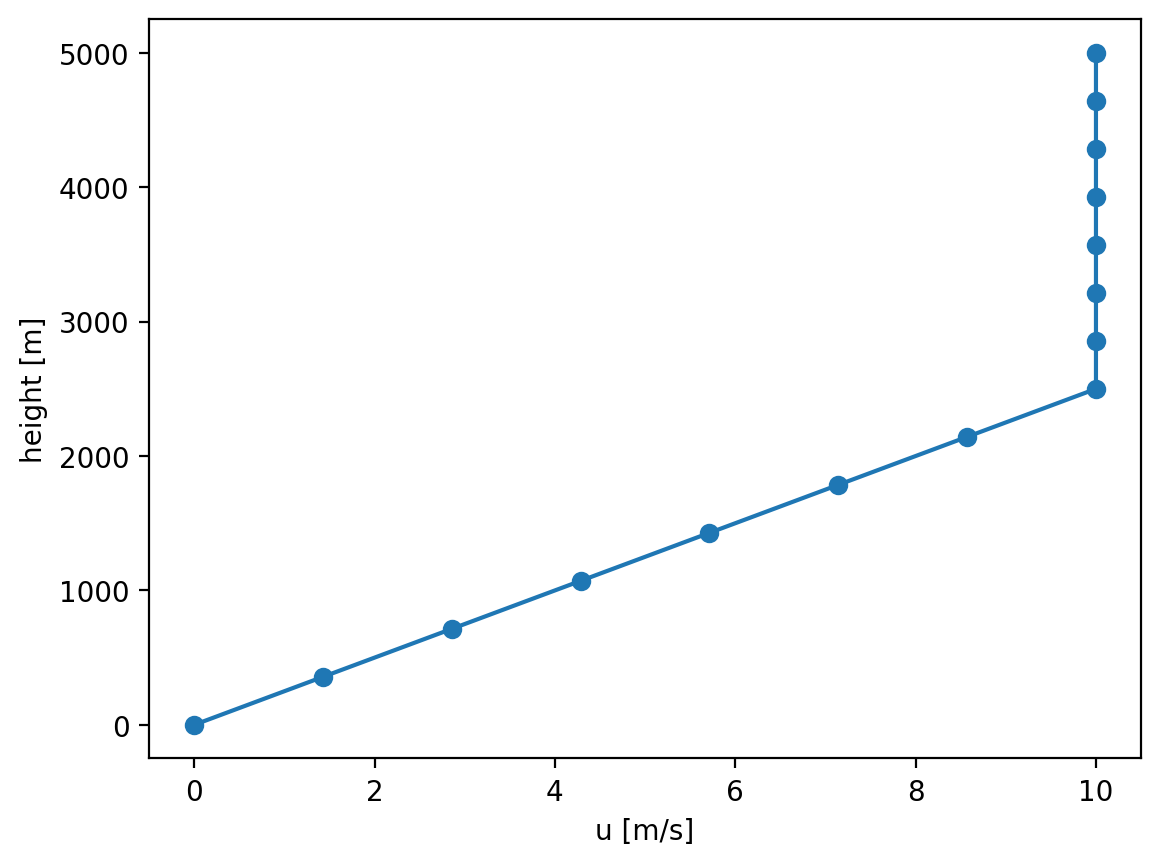

In [4]:
fig, ax = plt.subplots()
ax.plot(u, zh)
ax.scatter(u, zh)
ax.set_xlabel("u [m/s]")
ax.set_ylabel("height [m]")
fig.savefig("../figs/windprofil.png", bbox_inches="tight")